## Day 10: Harris Corner Detection

#### Goals
* Know what is meant by **local image features**.
* Understand the motivation for **detecting**, **describing**, and **matching** local image **features**.
* Understand why **uniqueness** and **invariance** are desirable properties of features and their descriptors.
* Know how to detect corner features using the Harris corner detector.

In [17]:
# boilerplate setup
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

### What makes good features?

* **Uniqueness**: features **shouldn't** match if they're from different points in the scene.  
* **Invariance**: features **should** match if they do come from the same point in the scene.

##### Discussion Question

In terms of uniqueness and invariance, discuss why arbitrary single pixels, described using their RGB values, would not make good features for image matching.

What might be a *little* bit better?

Idea: patches. Is it perfect?

![](../data/fences.jpg)

No! But it's hard to imagine something that is. Let's settle for this and talk about how to find patches that will be **locally** unique.

#### Question: what sorts of points will be matchable from one image to another? 

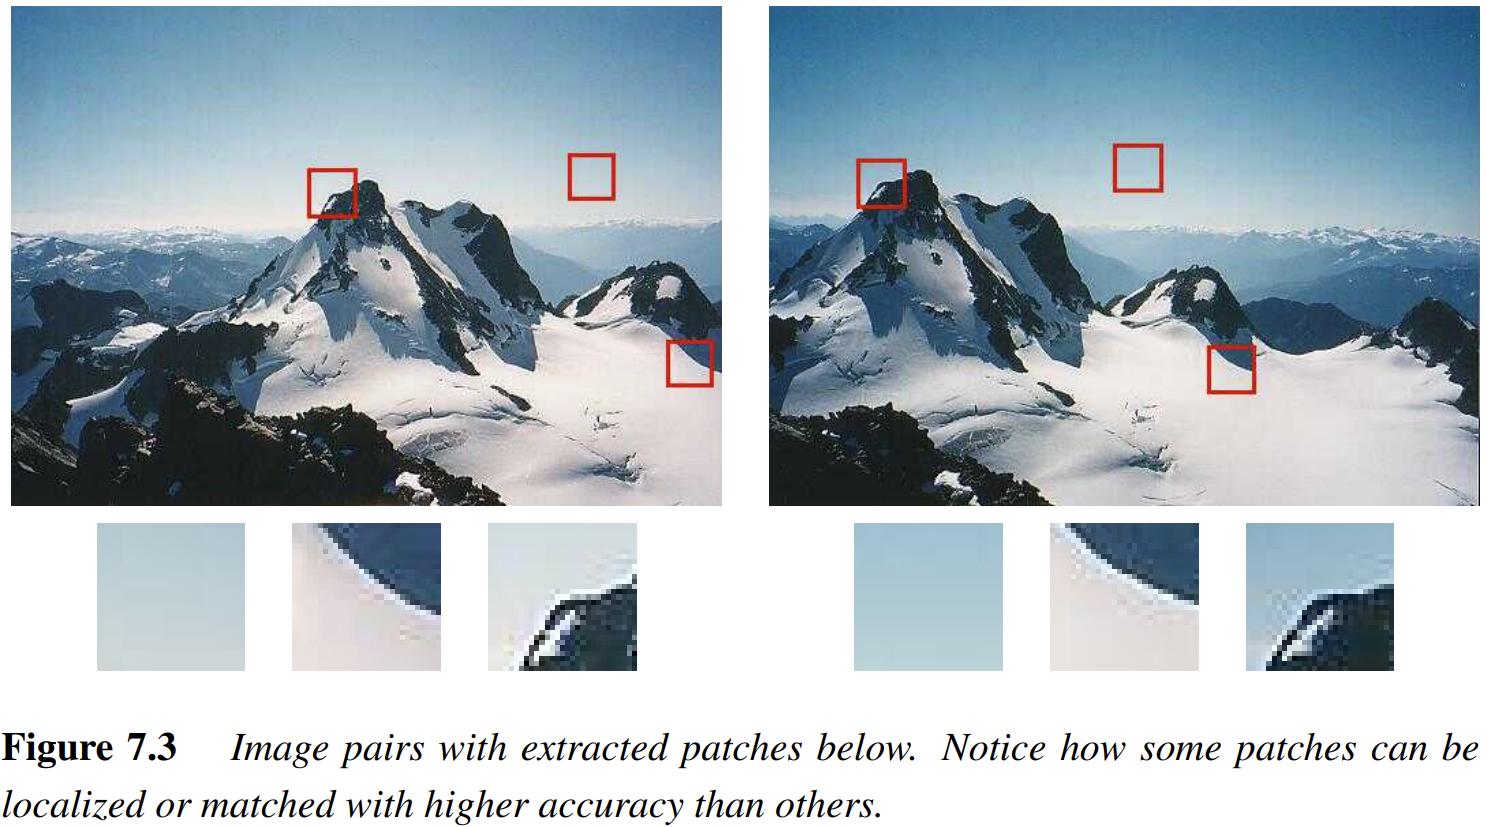

(Source: Szeliski 2ed. Figure 7.3)

### Harris Corner Detection

Here are the rough notes used for the whiteboard presentation.

##### Idea: the thing that goes wrong:
1. If I shift my patch a little distance in some direction, and it looks almost the same, that's bad.
2. It doesn't have to look the same in all directions. If there's even one direction where the patch looks the same after a shift then that's a failure case.
3. Can we measure the "shiftability" of a patch?

##### Attempt 1 at a solution
Hey how much something changes in a direction... this sounds like a gradient magnitude!

* Right angle example - this seems like it's going to work!
* Diagonal line example - darn. This isn't going to work.

##### Attempt 2 at a solution
Throw out the gradient idea and brute force it: compare a patch to all its neighbors. 

Let's call our point of interest $(x^*, y^*)$. Choose a window $W$ around that point. Do the usual thing: $W$ is square, and its width/height is an odd number $L$, and it's centered on $(x^*, y^*)$. Describe the window as a set of pixels $(x,y) \in W$.

* Evaluate a particular shift $(u,v)$ and compute a distance.
  * $E(u, v) = \sum_{x, y \in W} \left[ I(x+u, y+v) - I(x, y) \right]^2$​​​
  * For each pixel (x, y) in the window, compare the pixel at (u,v) offset from (x, y) to the un-offset (x, y)

**Q**: Suppose we did that, and distance measurements from many offset windows. How would you turn that into a single "shiftableness" score?

**A**: The **minimum** distance would work - a small minimum distance is a shiftable patch, and a large minimum distance means this should be a matchable patch.

##### Attempt 3 at a solution (this one works!)

Okay but this is really expensive.
* **for** each candidate match point $(x^*, y^*)$,
  * **for** each offset $(u,v)$
    * **for** each pixel $(x,y)$ in the patch around $(x^*, y^*)$
      * square / add stuff up

**Idea:** Approximate the offset error function $E(u,v)$

Taylor expansion reminder:
$$
f(x) = f(a) + f'(a)(x-a) + f''(a)(x-a)^2 + \ldots
$$
For a first-order (linear) Taylor approximation,
$$
f(x) \approx f(a) + f'(a)(x-a)
$$


In our bivariate context:
$$
I(x+u, y+v) \approx I(x, y) 
+ \frac{\partial{I}}{\partial x} u 
+ \frac{\partial{I}}{\partial y} v
$$
Look, the derivatives came back!

Plug this into our "error" function:
$$
\begin{align}
E(u, v) &= \sum_{x, y \in W} \left[  I(x+u, y+v) - I(x, y) \right]^2\\
&\approx \sum_{x, y \in W} \left[
	I(x, y) + \frac{\partial{I}}{\partial x} u
  						+ \frac{\partial{I}}{\partial y} v -  I(x, y))\right]^2\\
&\approx \sum_{x, y \in W} \left[
						  \frac{\partial{I}}{\partial x} u
                + \frac{\partial{I}}{\partial y} v\right]^2
\end{align}
$$

**Pause** At this point, it's fair to ask what the heck we're looking at.

### Visualizing the error function

Here's a visualization of the error function $E(u, v)$ as we shift a patch around in a real image.
* Top left: the original image with the patch highlighted
* Top right: the actual error computed by shifting that patch to each position in a (by default 13x13) window.
* Bottom left: the approximate error function computed by substituting the linearized approximation based on the derivatives.
* Bottom right: a contour plot of the same data as the bottom left.

Notice that the top right and bottom left are 3D plots, so you can drag them to change views.

In [18]:
# Visualization code for Harris corner detection
import matplotlib.patches as patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def visualize_harris(img, i, j, topdown=True, window_halfwidth=3, error_surface_halfwidth=6):
    """ Visualize the Harris corner error function
    img: grayscale float image
    i, j: image coordinates of the candidate keypoint to visualize
    topdown: whether to default to a top-down view of the error surface
    """
    k = window_halfwidth # Harris window is a square with side length 2k+1
    uv_k = error_surface_halfwidth # size of the error surface grid (a 2uv_k+1 square)
    
    # center of window (i.e., feature location)
    y, x = i, j
    
    ## plot the image with a red box around the window
    fig = plt.gcf()
    fig.clf()
    fig.set_size_inches(8, 8)
    
    plt.subplot(2, 2, 1, title="Window around the candidate feature point")
    plt.imshow(img, cmap='gray')
    box = patches.Rectangle((x-k-1, y-k-1), 2*k+1, 2*k+1, # (left, bottom), width, height
                            linewidth=1, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(box)
    
    
    ## compute measured E(u,v) for a grid of nearby offsets
    I = img.copy()
    ys, ye = y-k, y+k+1 # start and end of the patch y range
    xs, xe = x-k, x+k+1 # start and end of the patch x range
    e_true = np.zeros((2*uv_k+1,2*uv_k+1))
    orig_patch = I[ys:ye, xs:xe]
    for u in range(-uv_k, uv_k + 1):
      for v in range(-uv_k, uv_k + 1):
        e_true[u+uv_k, v+uv_k] = np.sum((orig_patch - I[ys+u:ye+u, xs+v:xe+v])**2)
    
    # plot it
    ax = plt.subplot(2, 2, 2, projection='3d', title="E(u,v) actual")
    X, Y = np.meshgrid(range(-uv_k, uv_k + 1), range(-uv_k, uv_k + 1))
    ax.set_proj_type('ortho')
    ax.plot_surface(Y, X, e_true, cmap=cm.coolwarm)
    ax.set_zlim(0, 4)
    if topdown:
        ax.view_init(elev=90, azim=0)   
    
    ## compute approximate E(u,v) based on first-order Taylor approximation
    # Use OpenCV's Sobel for consistency with harris_score
    Ix = cv2.Sobel(I, cv2.CV_32F, 1, 0, ksize=3, scale=1/8)
    Iy = cv2.Sobel(I, cv2.CV_32F, 0, 1, ksize=3, scale=1/8)
    
    e_approx = np.zeros_like(e_true)
    orig_patch = I[ys:ye, xs:xe]
    for u in range(-uv_k, uv_k + 1):
      for v in range(-uv_k, uv_k + 1):
        Ixu = (Ix[ys:ye, xs:xe])*u
        Iyv = (Iy[ys:ye, xs:xe])*v
        e_approx[u+uv_k, v+uv_k] = np.sum((Ixu + Iyv)**2)
    
    # plot it
    ax = plt.subplot(2, 2, 3, projection='3d', title="E(u,v) approximate")
    X, Y = np.meshgrid(range(-uv_k, uv_k + 1), range(-uv_k, uv_k + 1))
    ax.set_proj_type('ortho')
    ax.plot_surface(X, Y, e_approx, cmap=cm.coolwarm)
    ax.set_zlim(0, 10)
    if topdown:
        ax.view_init(elev=90, azim=0)

    ax = plt.subplot(2, 2, 4, title="E(u,v) approximate contours")
    ax.contour(e_approx.T, cmap=cm.coolwarm)
    plt.show()

In [19]:
# Load test images
h = cv2.imread("../data/harris_crop.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

hfull = cv2.imread("../data/harris.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

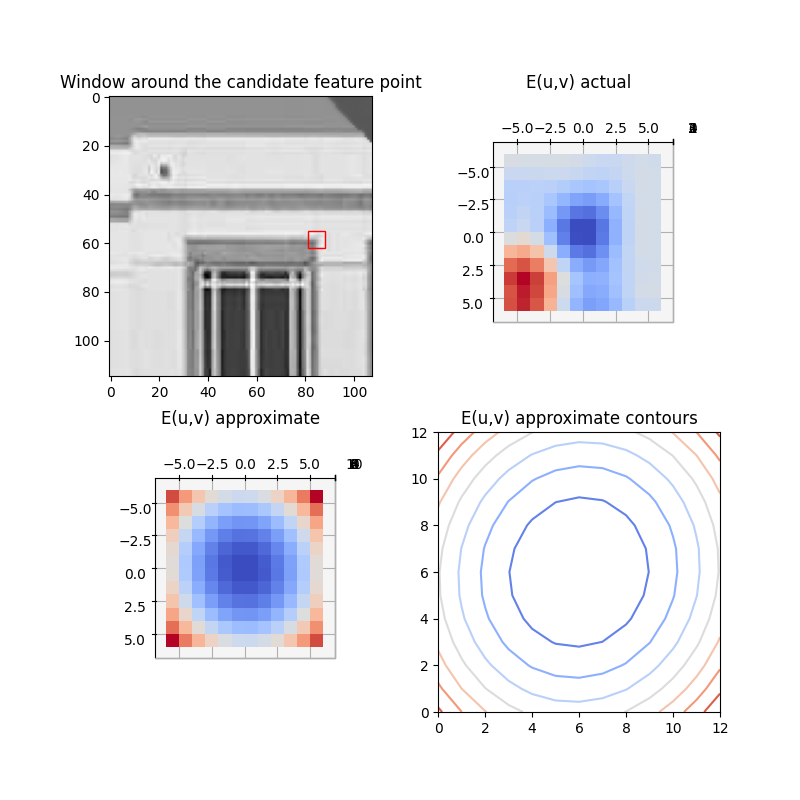

In [20]:
%matplotlib widget

# Try different points:
# visualize_harris(h, 30, 60)
visualize_harris(h, 59, 85)
# visualize_harris(h, 72, 60)
# visualize_harris(h, 30, 26)

##### Discussion Question

Play around with this visualization and answer the following:

For each of the following (linearized) error function shapes, describe the image patch that gave rise to it:

1. Flat in all directions
2. Steep in one direction, flat in the orthogonal direction
3. Steep in all directions

The linearized error function is now a 2D quadratic! We can see that depending on the image patch content, its shape varies in steepness in different directions. What we're after is points whose error is steep in all directions: these are least likely to be confused with their neighbors, or in other words, corner-like!

Okay, onward with the math that will tell us about steepness-in-different-directions!

### The Structure Tensor

Let's make some shorthand. Let:
$$
I_x = \frac{\partial{I}}{\partial x}
$$
$$
I_y = \frac{\partial{I}}{\partial y}
$$

So now we have:
$$
E(u, v) \approx \sum_{x, y \in W} \left[ I_xu + I_yv \right]^2
$$
FOIL!
$$
E(\mathbf{u}) \approx \sum_{\mathbf{x} \in W} \left[ I_x^2u^2 + 2I_xI_yuv + I_y^2v^2 \right]
$$
Now rewrite this as a matrix-vector product:
$$
E(u, v) \approx
\sum_{\mathbf{x} \in W} \left(
\begin{bmatrix} u & v \end{bmatrix}
\begin{bmatrix}
I_x^2  & I_xI_y \\
I_xI_y &  I_y^2 \\
\end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
\right)
$$
Pull the sums into the matrix:

$$
E(u, v) \approx
\begin{bmatrix} u & v \end{bmatrix}
\begin{bmatrix}
\sum I_x^2  & \sum I_xI_y \\
\sum I_xI_y & \sum I_y^2 \\
\end{bmatrix}
\begin{bmatrix} u \\ v \end{bmatrix}
$$
This matrix is called the **structure tensor**, and it gives us a compact way to measure corneriness.

### Eigenvalues and the Ellipse Interpretation

The error function we get after the linear approximation always represents a 2D quadratic (see the visualization examples in the notebook). That quadratic could be:
* very wide and shallow (which happens for flat patches in the image)
* wide in one direction but steep in the orthogonal direction (which happens for patches that lie on edges)
* steep in all directions (which happens for corner patches)

It turns out that the **eigenvectors and eigenvalues** of the structure tensor matrix above can tell us which of these cases we're in! You may recall that an eigenvector/eigenvalue pair is a vector $v$ and a scalar $\lambda$ such that $Av = \lambda v$. There's a geometric interpretation in which the eigenvectors and eigenvalues determine the major and minor axes of an ellipse:

![](../data/harris_ellipse.jpg)

Here, the ellipse traces out a line of constant value in the error function $E(u, v)$. The direction of the major and minor axes are determined by the eigenvectors ($\mathbf{v}_1$ and $\mathbf{v}_2$), while their lengths are inversely proportional to the (square root of) the eigenvalues. A small eigenvalue makes for a longer axis, while a larger eigenvalue makes for a shorter axis - in other words, you have to go less far to get a given amount of error.

If corners are points where the error goes up really fast, then a good metric for corneriness is the size of the *smaller* eigenvalue. If both eigenvalues are large, then there is no direction you can move for very long while maintaining small error, or in other words, the patch cannot be confused with its neighbors in any direction. If either eigenvalue is small, then you can move in the direction of its eigenvector and maintain low error.

### Computing the Harris Score

We're interested in the eigenvalues of the structure tensor matrix:

$$
\begin{bmatrix}
\sum I_x^2  & \sum I_xI_y \\
\sum I_xI_y & \sum I_y^2 \\
\end{bmatrix}
$$
How do we actually compute this? 

Recall that the summations $\left(\sum\right)$  are over all pixels in a window around the pixel in question. That sounds familiar... we can do this with convolution!

Here's an approach that accomplishes this for every pixel in an image, all in one go:

* Calculate gradients with Sobel filters

* From this, compute three images representing $I_x^2$,  $I_xI_y$, and $I_y^2$

* Blur each of these three images with a Gaussian filter
  * Why? It works better!

* Call those three blurred images $A, B, C$; we now have the elements of the matrix
  $$
  \begin{bmatrix}
  A  & B \\
   B & C \\
  \end{bmatrix}
  $$
  for every pixel in the image! 

* Calculate its eigenvalues (formula for 2x2 matrix):

  * Let $d = AC - BB$​
  * Let $t = \frac{A+C}{2}$
  * $ \lambda_1, \lambda_2 = t \pm \sqrt{t^2 - d}$

* The smaller of these two at each pixel will be the Harris score!

In [21]:
# Filtering functions for Harris corner detection

def compute_gradients(img):
    """ Compute image gradients using OpenCV's Sobel operator.
    Returns dx, dy (both same shape as img). """
    # cv2.Sobel computes derivatives using Sobel operator
    # ksize=3 uses 3x3 Sobel kernels (standard)
    # scale=1/8 normalizes the Sobel output
    dx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    dy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    return dx, dy

def maximum_filter(img, filter_size):
    """ Apply a square spatial maximum filter with side length filter_size
    to a grayscale img. Preconditions:
      - img is a grayscale (2d) float image
      - filter_size is odd """
    H, W = img.shape
    out = np.zeros_like(img)

    hw = filter_size // 2 # half-width

    in_pad = np.pad(img, ((hw, hw), (hw, hw)))
    
    for i in range(H):
        for j in range(W):
            out[i,j] = in_pad[i:hw+i+hw+1, j:hw+j+hw+1].max()
    return out

In [22]:
def harris_score(img):
    """ Returns the smaller eigenvalue of the structure tensor for each pixel in img.
    Pre: img is grayscale, float, [0,1]. Returns an array the same shape as img."""
    # Compute gradients using OpenCV's Sobel operator
    dx, dy = compute_gradients(img)
    
    # Compute products of derivatives and blur them
    # cv2.GaussianBlur with ksize=(5,5) approximates the binomial kernel
    A = cv2.GaussianBlur(dx * dx, (5, 5), 0)
    B = cv2.GaussianBlur(dx * dy, (5, 5), 0)
    C = cv2.GaussianBlur(dy * dy, (5, 5), 0)

    # Compute eigenvalues of the structure tensor
    det = A*C - B*B
    tr = A+C
    
    m = tr / 2
    p = det
    sqrtm2mp = np.sqrt(m**2 - p)
    eig1 = m - sqrtm2mp
    eig2 = m + sqrtm2mp
    return np.minimum(eig1, eig2)

def overlay_features(img, corners):
    """ Overlay detected corners on a grayscale image as red dots. """
    h, w = img.shape
    out = np.zeros((h, w, 3))
    out[:,:,:] = img[:,:,np.newaxis] / 2
    out[corners>0, :] = [1, 0, 0]
    return out

### Testing the Harris Score

Now let's compute Harris scores for an entire image and visualize them!

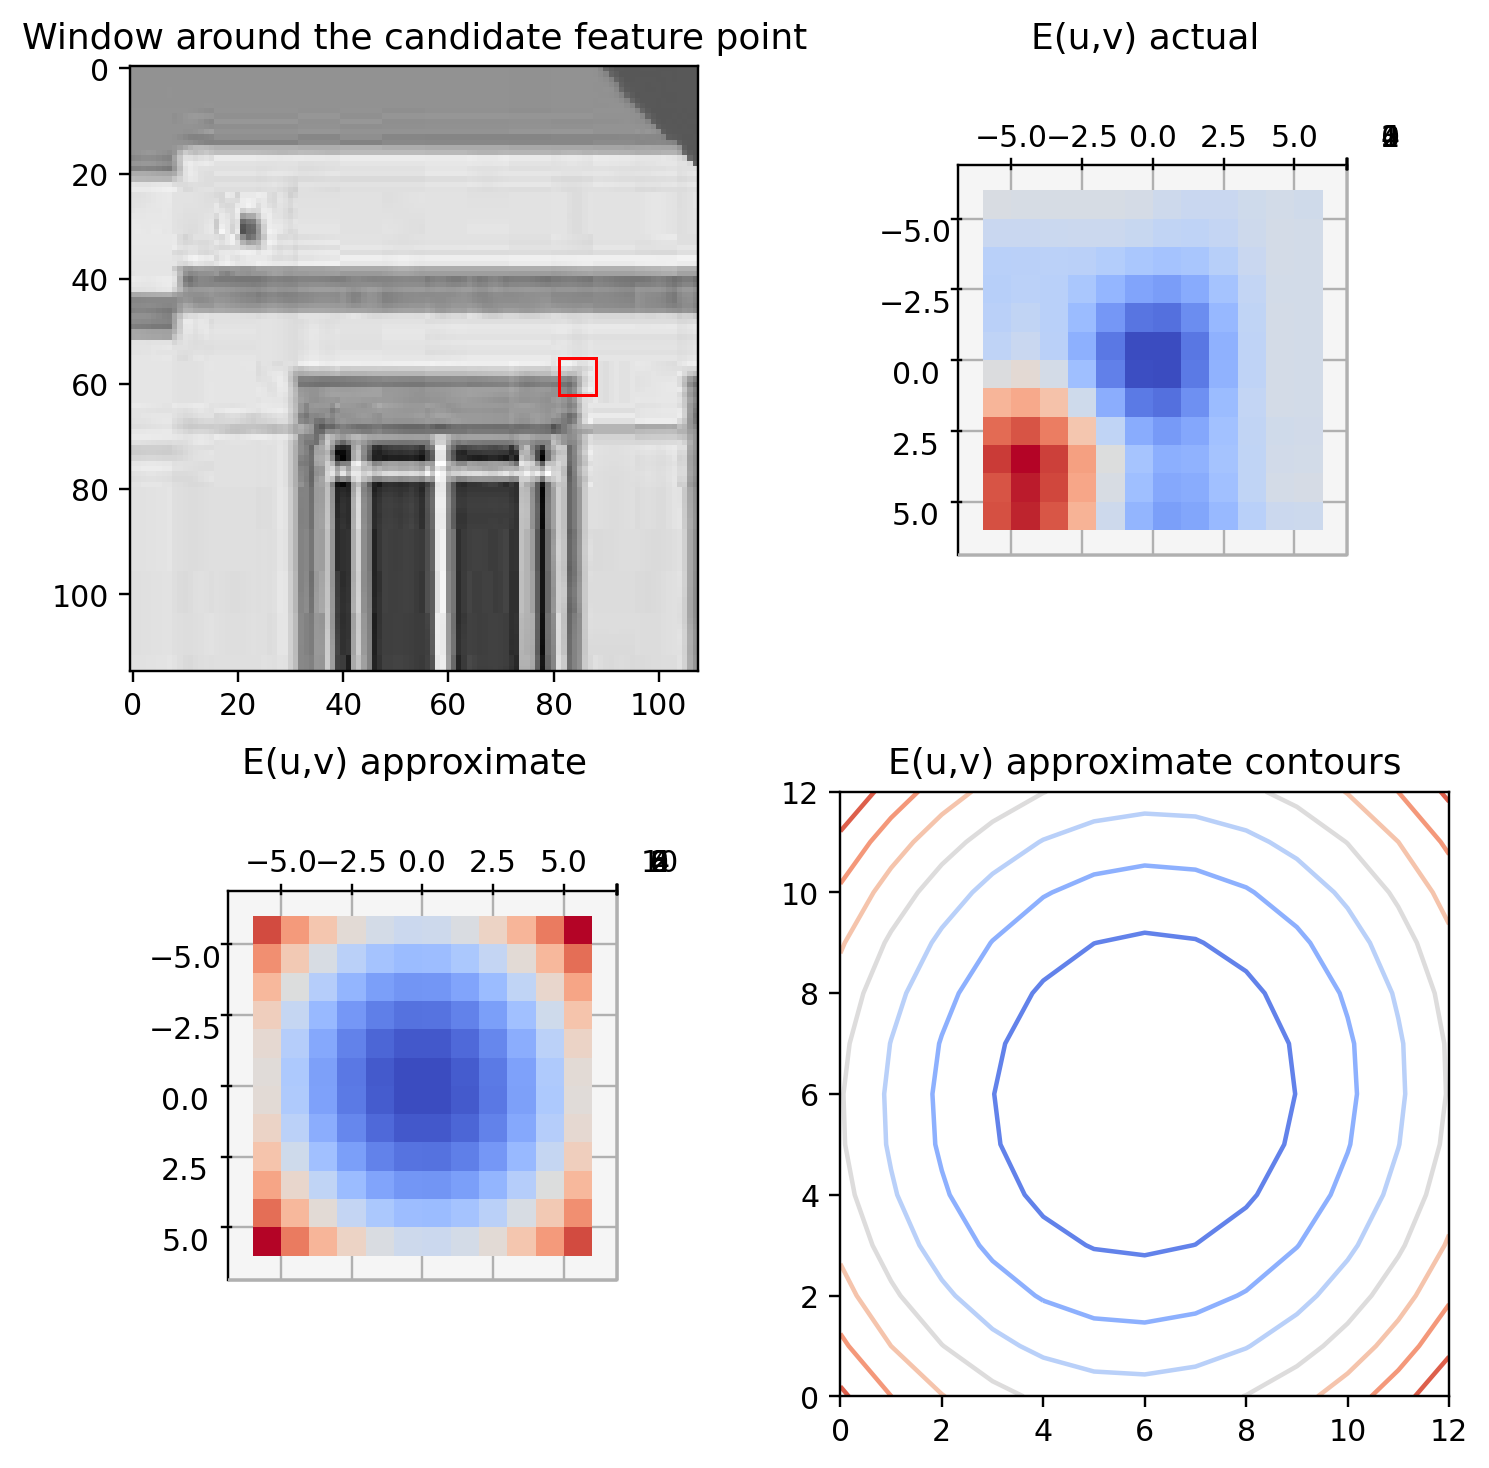

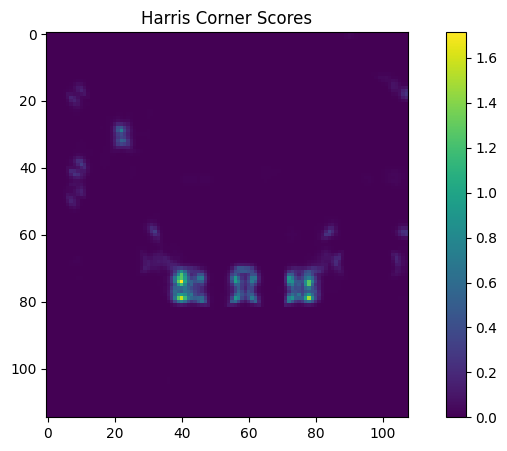

In [23]:
%matplotlib inline

img = h # or use hfull for the full image

plt.figure(figsize=(10, 5))
scores = harris_score(img)
plt.imshow(scores)
plt.colorbar()
plt.title("Harris Corner Scores")
plt.show()

### Thresholding and Non-Maximum Suppression

Next steps: thresholding to find strong corners, and non-maximum suppression to avoid duplicate detections

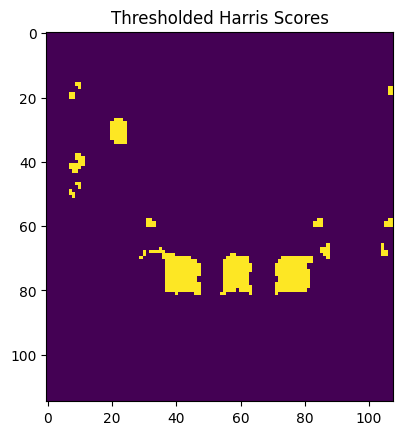

In [24]:
# Simple thresholding
threshold = 0.1
plt.imshow(scores > threshold)
plt.title("Thresholded Harris Scores")
plt.show()

**Non-Maximum Suppression:**
1. Apply maximum filter
2. Keep only pixels that are equal to the max-filtered image

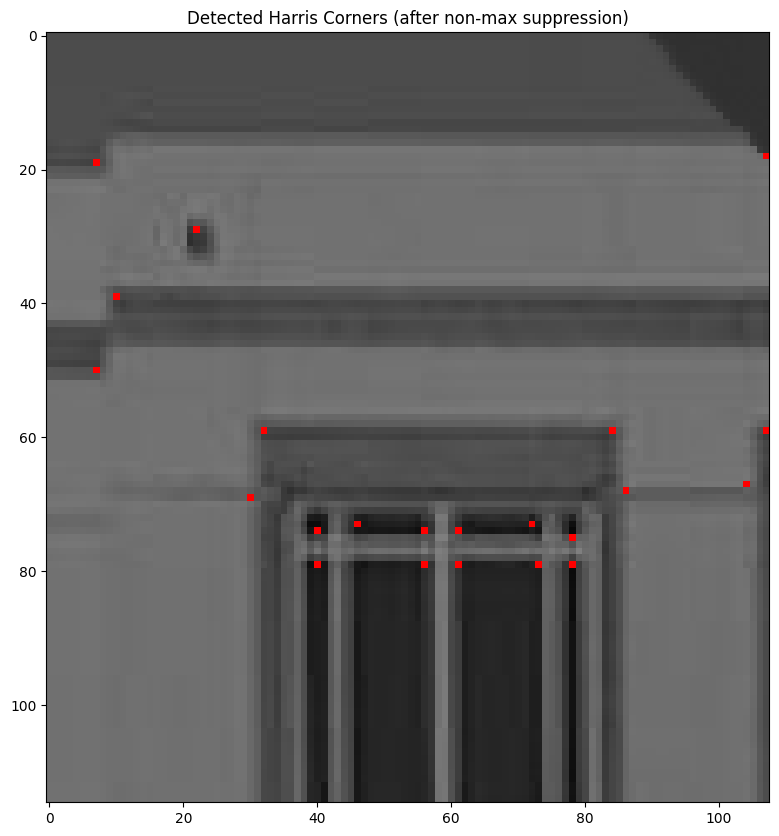

In [25]:
scores_maxfilter = maximum_filter(scores, 7)
features_mask = np.logical_and(scores > threshold, scores == scores_maxfilter)
plt.figure(figsize=(10, 10))
plt.imshow(overlay_features(img, features_mask))
plt.title("Detected Harris Corners (after non-max suppression)")
plt.show()

In [26]:
# Putting it all together:

def harris(img, threshold):
    """ Complete Harris corner detection pipeline. """
    scores = harris_score(img)
    scores_maxfilter = maximum_filter(scores, 7)
    features_mask = np.logical_and(scores > threshold, scores == scores_maxfilter)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay_features(img, features_mask))
    plt.title(f"Harris Corners (threshold={threshold})")
    plt.show()
    return features_mask

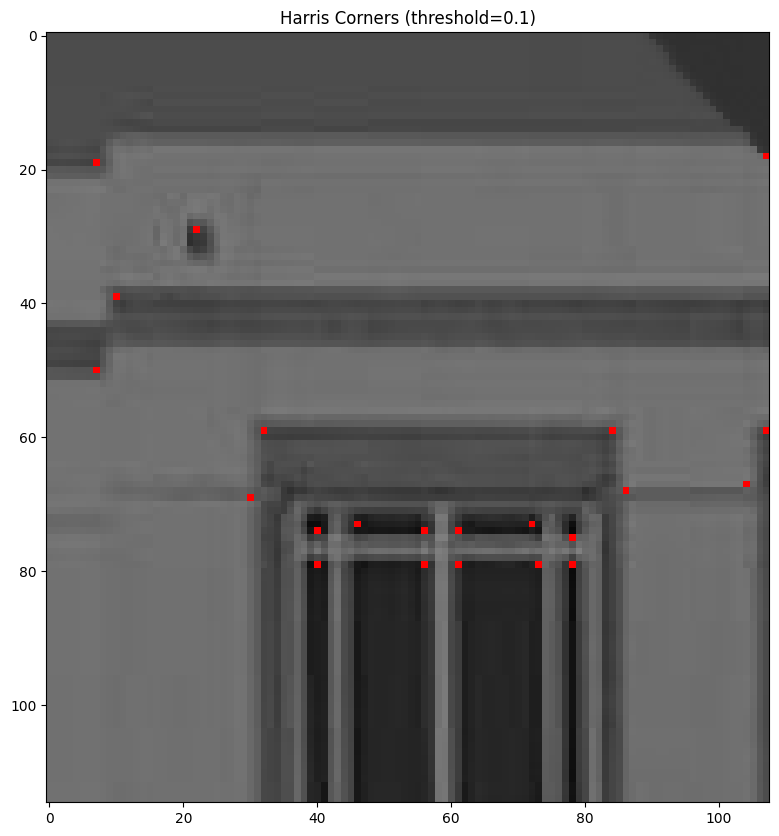

In [27]:
# Try it out!
harris(h, 0.1);